### Explore the data


In [2]:
# Load the required packages and make them available in your current R session
suppressPackageStartupMessages({
  library(tidyverse)
  library(palmerpenguins)
  library(tidymodels)
})

# Take a peek into the data
glimpse(penguins)


Rows: 344
Columns: 8
$ species           <fct> Adelie, Adelie, Adelie, Adelie, Adelie, Adelie, Adel…
$ island            <fct> Torgersen, Torgersen, Torgersen, Torgersen, Torgerse…
$ bill_length_mm    <dbl> 39.1, 39.5, 40.3, NA, 36.7, 39.3, 38.9, 39.2, 34.1, …
$ bill_depth_mm     <dbl> 18.7, 17.4, 18.0, NA, 19.3, 20.6, 17.8, 19.6, 18.1, …
$ flipper_length_mm <int> 181, 186, 195, NA, 193, 190, 181, 195, 193, 190, 186…
$ body_mass_g       <int> 3750, 3800, 3250, NA, 3450, 3650, 3625, 4675, 3475, …
$ sex               <fct> male, female, female, NA, female, male, female, male…
$ year              <int> 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007…


The data contains the following columns:

-   **species:** a factor denoting the penguin species (*Adelie*, *Chinstrap*, or *Gentoo*)

-   **island:** a factor denoting the island (in Palmer Archipelago, Antarctica) where observed

-   **bill_length_mm (aka culmen_length):** a number denoting length of the dorsal ridge of penguin bill (millimeters)

-   **bill_depth_mm (aka culmen_depth):** a number denoting the depth of the penguin bill (millimeters)

-   **flipper_length_mm:** an integer denoting penguin flipper length (millimeters)

-   **body_mass_g:** an integer denoting penguin body mass (grams)

-   **sex:** a factor denoting penguin sex (male, female)

-   **year:** an integer denoting the study year (2007, 2008, or 2009)

The **species** column containing penguin species *Adelie*, *Chinstrap*, or *Gentoo*, is the label we want to train a model to predict.


In [9]:
# Load the skimr column
library(skimr)

# Select desired columns
penguins_select <- penguins %>%
  select(c(bill_length_mm, bill_depth_mm, flipper_length_mm,
           body_mass_g, species))

Let's discard rows that contain no feature values at all (`NA` - Not Available values), since they won't be useful in training a model. 



In [10]:
# Drop rows containing missing values
penguins_select <- penguins_select %>%
  drop_na()

# Proportion of each species in the data
penguins_select %>%
  count(species)


species,n
<fct>,<int>
Adelie,151
Chinstrap,68
Gentoo,123


Now that we've dealt with the missing values, let's explore how the features relate to the label by creating some box charts.



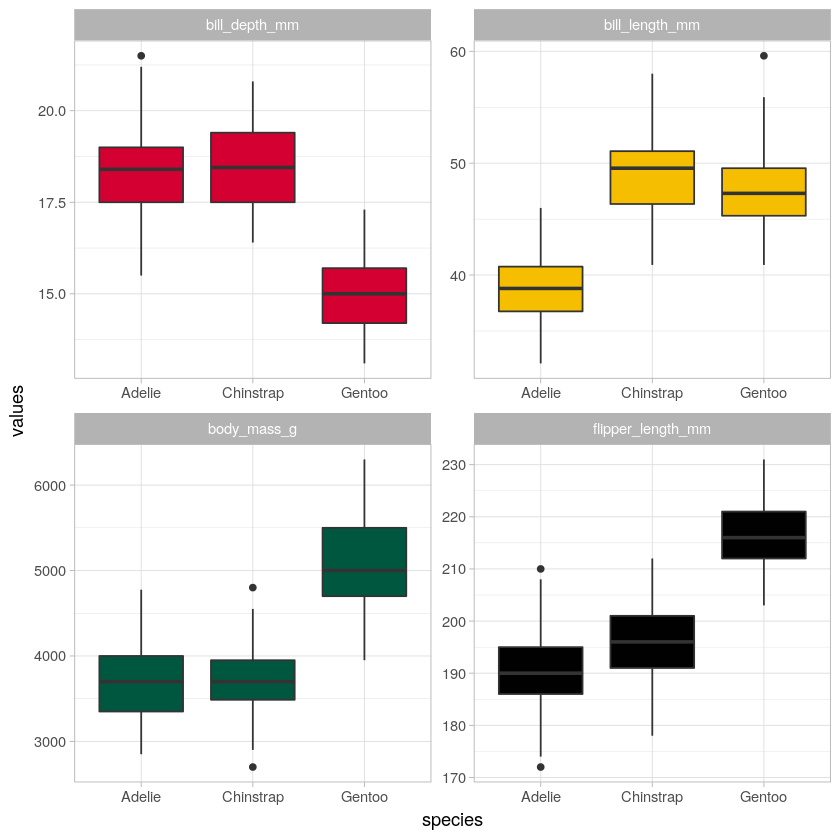

In [11]:
# Load the paletteer package
library(paletteer)

# Pivot data to a long format
penguins_select_long <- penguins_select %>% 
  pivot_longer(!species, names_to = "predictors", values_to = "values")

# Make box plots
theme_set(theme_light())
penguins_select_long %>%
  ggplot(mapping = aes(x = species, y = values, fill = predictors)) +
  geom_boxplot() +
  facet_wrap(~predictors, scales = "free") +
  scale_fill_paletteer_d("nbapalettes::supersonics_holiday") +
  theme(legend.position = "none")

From the box plots, it looks like species *Adelie* and *Chinstrap* have similar data profiles for bill_depth, flipper_length, and body_mass, but *Chinstraps* tend to have longer bill_length. *Gentoo* tends to have fairly clearly differentiated features from the others; which should help us train a good classification model.

### Prepare the data

Just as for binary classification, before training the model, we need to split the data into subsets for training and validation. We'll also apply a *stratification* technique when splitting the data to *maintain the proportion of each label value* in the training and validation datasets.


In [12]:
# For reproducibility
set.seed(2056)

# Split data 70%-30% into training set and test set
penguins_split <- penguins_select %>% 
  initial_split(prop = 0.70, strata = species)

# Extract data in each split
penguins_train <- training(penguins_split)
penguins_test <- testing(penguins_split)

# Print the number of observations in each split
cat("Training cases: ", nrow(penguins_train), "\n",
    "Test cases: ", nrow(penguins_test), sep = "")


Training cases: 238
Test cases: 104

In [13]:
# Build a random forest model specification
rf_spec <- rand_forest() %>%
  set_engine("ranger", importance = "impurity") %>%
  set_mode("classification")


# Create a workflow that encapsulates a recipe and a model
rf_wflow <- recipe(species ~ ., data = penguins_train) %>%
  step_normalize(all_numeric_predictors()) %>%
  workflow(rf_spec)

# Print out workflow
rf_wflow


In [25]:
# Fit a model
rf_wf_fit <- rf_wflow %>%
  fit(data = penguins_train)

# Make predictions for the test set
penguins_results <- penguins_test %>% select(species) %>%
  bind_cols(rf_wf_fit %>%
              predict(new_data = penguins_test)) %>%
  bind_cols(rf_wf_fit %>%
              predict(new_data = penguins_test, type = "prob"))

# Print predictions
penguins_results %>%
  slice_head(n = 50)


In [27]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
penguins_results %>%
  conf_mat(species, .pred_class) %>%
  autoplot(type = "heatmap")

In [30]:
# Statistical summaries for the confusion matrix
conf_mat(data = penguins_results, truth = species, estimate = .pred_class) %>% 
  summary()

In [29]:
# Make a ROC_CURVE
penguins_results %>%
  roc_curve(species, c(.pred_Adelie, .pred_Chinstrap, .pred_Gentoo)) %>%
  ggplot(aes(x = 1 - specificity, y = sensitivity, color = .level)) +
  geom_abline(lty = 2, color = "gray80", size = 0.9) +
  geom_path(show.legend = T, alpha = 0.6, size = 1.2) +
  coord_equal()